# Emergent time-locking attractors in rate network

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import sys

from my_stats import get_cmn_p
from disp import set_plot

cc = np.concatenate

DT = .001
N = 1000

RT = np.arange(0, 3., DT)
RX = np.arange(N, dtype=float)

def sgm(h):
    return (1 + np.tanh(h))/2

def plot_trj(ax, u_fn, w, t=None, xs=None, cscale=1, c_trj='k'):
    v_mat = 1 + u_fn(RT)[:, None]@w[None, :]
    ax.matshow(
        cscale*(v_mat.T-1), origin='lower', extent=[RT[0], RT[-1], RX[0], RX[-1]],
        vmin=-1, vmax=1, cmap='PuOr', zorder=0)  # pink = slow, g = fast, 1 = white
    
    if t is not None:
        [ax.plot(t, x, c=c_trj) for x in xs]
    
    ax.xaxis.tick_bottom()
    ax.set_aspect('auto')
    set_plot(ax, x_label='t', y_label='x')

In [2]:
P_0 = {
    'TAU': .05,
    'BETA': 10,
    'TH': 1,
    
    'J_0': 1,
    'J_INH': 0,
}

CXN_CHAIN = np.diag(np.ones(N-1), -1)

def smlt(t, w, u_fn, p, h_0=None, t_start=0):
    
    w_mat = np.diag(w[:-1], -1)
    TAU = p['TAU']
    
    phi = lambda h: sgm(p['BETA']*(h - p['TH']))
    
    J_0 = p['J_0']
    J_INH = p['J_INH']
    
    if h_0 is None:
        h_0 = 0
        
    hs = np.nan*np.zeros((len(t), N))
    hs[0, :] = h_0
    
    rs = np.nan*np.zeros((len(t), N))
    rs[0, :] = phi(hs[0, :])
    
    u = np.nan*np.zeros(len(t))
    u[0] = u_fn(t[0])

    for ct, t_ in enumerate(t[1:], 1):
        
        if t_ < t_start:
            hs[ct, :] = h_0
            rs[ct, :] = phi(hs[ct, :])
            continue
            
        u_ = u_fn(t_)
        u[ct] = u_
        
        J_FF = J_0*(CXN_CHAIN + w_mat*u_)
        
        J = J_FF + J_INH
        
        dh = (DT/TAU)*(-hs[ct-1, :] + J@rs[ct-1, :])
        
        hs[ct, :] = hs[ct-1, :] + dh
        rs[ct, :] = phi(hs[ct, :])
        
    return rs, hs, u

def get_x(rs):
    # estimate position by weighting nrn idxs w activity
    return (rs / rs.sum(axis=1)[:, None])@RX

def get_spd(x, t, mt):
    spd, icpt, _, _, _ = stats.linregress(t[mt], x[mt])
    return spd

In [3]:
W_SMALL = -.1
W_BIG = -.7

def update_w(w, t, rs, u, r_th=10, delta=0):
    atvy = (rs.T > r_th)
    
    # take time integral of each neuron's activation times shifted input
    if delta > 0:
        ishift = int(np.round(delta/DT))
        u_shifted = cc([np.zeros(ishift), u[:len(u)-ishift]])
    elif delta < 0:
        ishift = int(np.round(np.abs(delta/DT)))
        u_shifted = cc([u[ishift:], np.zeros(ishift)])
    else:
        u_shifted = u.copy()
        
    mx = (atvy@u_shifted > 0)
    w_new = w.copy()
    w_new[mx] = W_BIG
    
    # forgetting
    w_new[~mx] = W_SMALL
    
    return w_new, atvy, mx

Round 0
...
Round 1
...
Round 2
...
Round 3
...
Round 4
...
Round 5
...
Round 6
...
Round 7
...
Round 8
...
Round 9
...


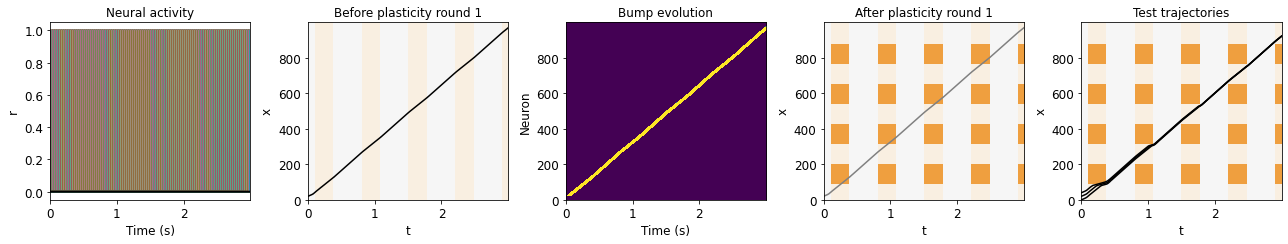

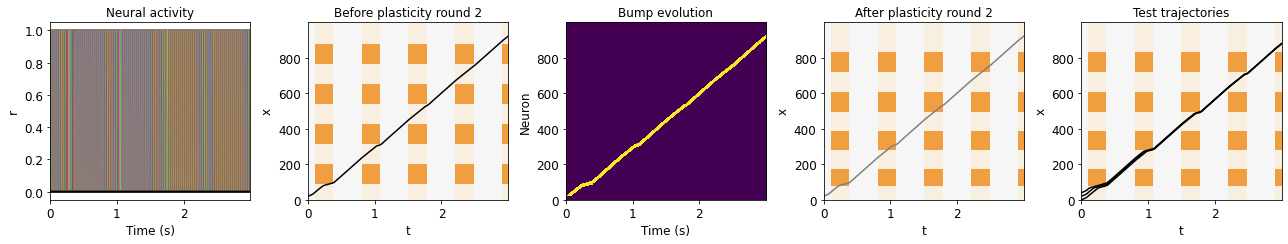

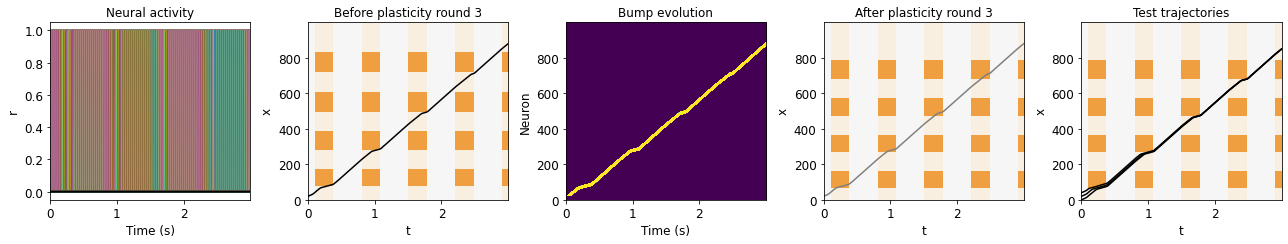

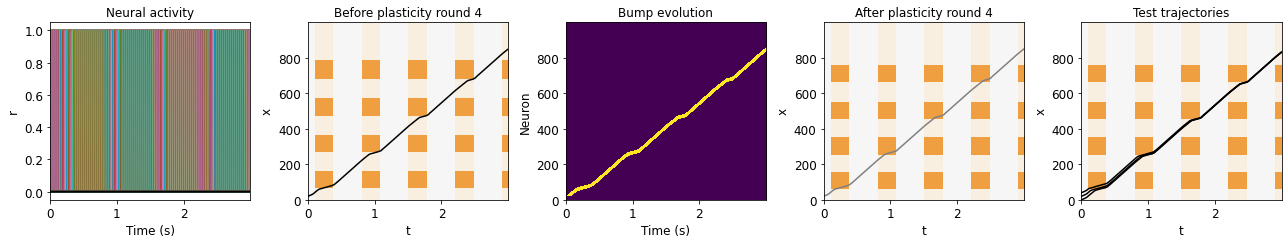

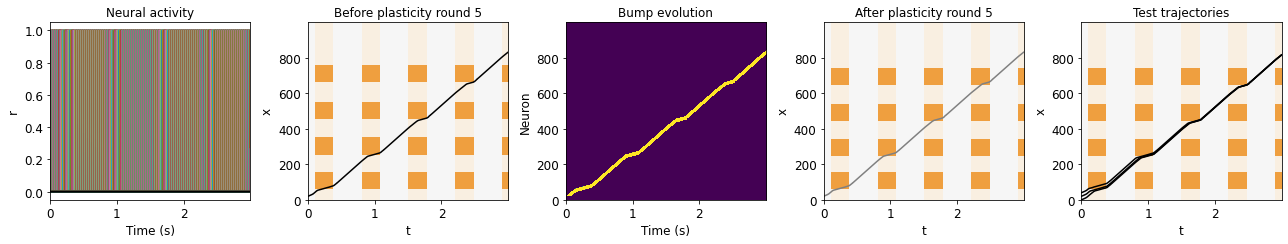

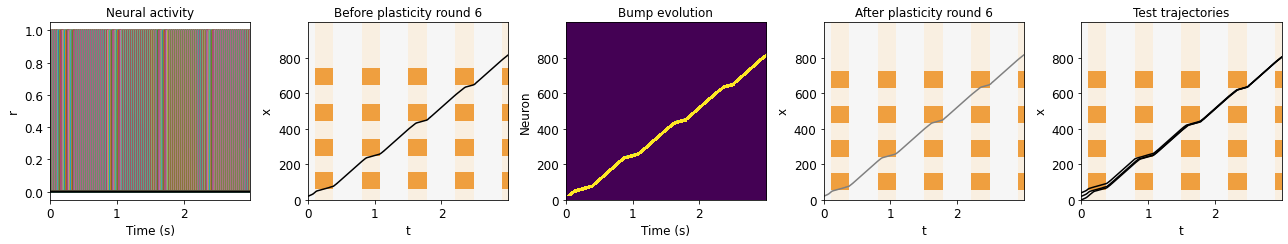

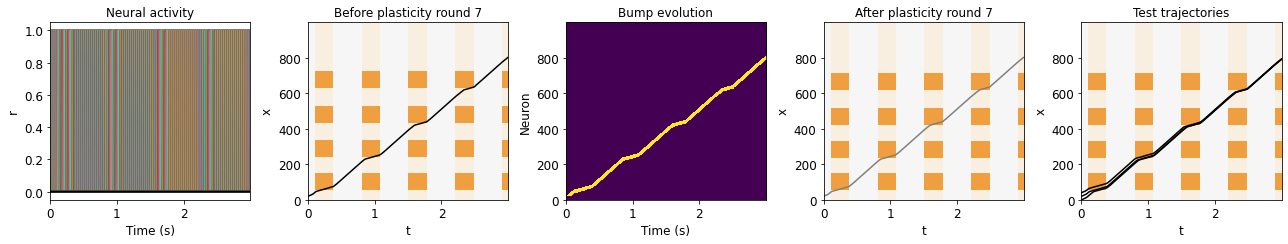

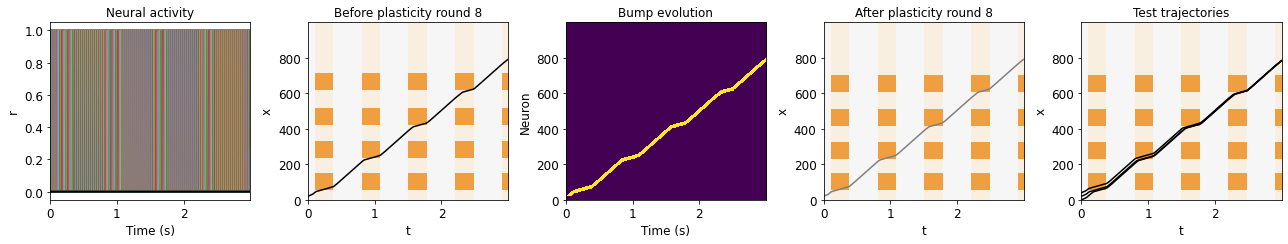

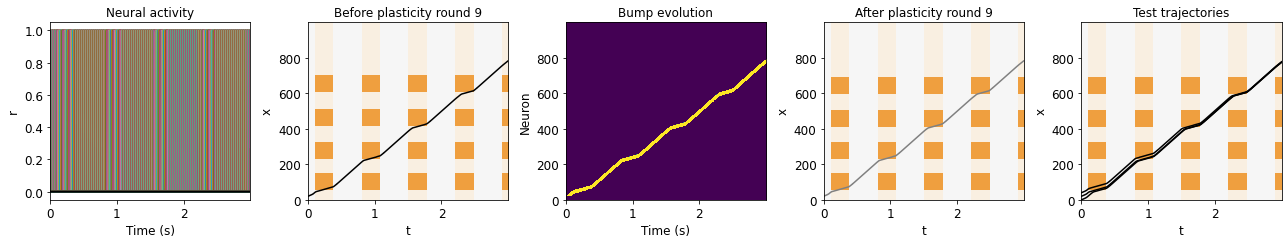

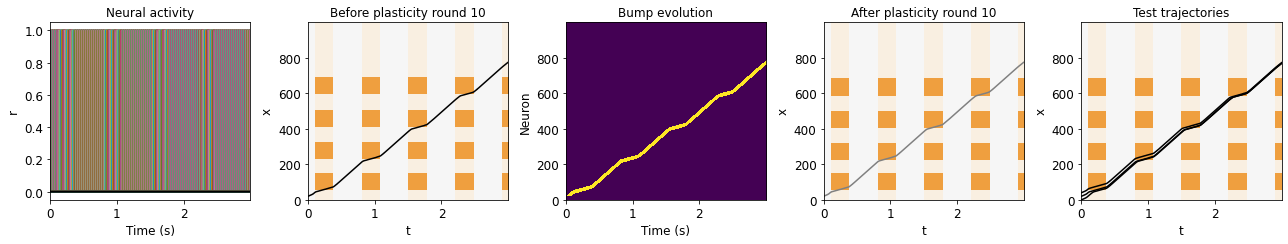

In [4]:
U_FN = lambda t_: .5*(1+signal.square(2*np.pi*(t_-.1)/.7, duty=.4))  # non-negative square wave modulation

W = W_SMALL*np.ones(N)  # initial weights
DELTA = .2

J_0 = 20

J_0_I = -50
INH_OFF = 20
J_INH = J_0_I*np.diag(np.ones(N-INH_OFF), INH_OFF)

X_0 = 20
H_0 = 20*np.eye(N)[X_0, :]

t = np.arange(0, 3., DT)
X_0_TESTS = [20, 0, 40]

w = W.copy()

for ctr in range(10):
    print('Round', ctr)
    
    p = P_0.copy()
    p['J_0'] = J_0
    p['J_INH'] = J_INH
    
    rs, hs, u = smlt(t, w, U_FN, p=p, h_0=H_0)
    
    ps = np.array([r/np.sum(r) for r in rs])
    x_mn = np.array([RX@p for p in ps])
    
    # update w
    w_new, _, _ = update_w(w, t, rs, u, r_th=.5, delta=DELTA)
    
    rs_tests = []
    x_mn_tests = []
    
    for x_0_test in X_0_TESTS:
        sys.stdout.write('.')
        
        h_0 = 20*np.eye(N)[x_0_test, :]
        rs_test, _, _ = smlt(t, w_new, U_FN, p=p, h_0=h_0)
        ps_test = np.array([r/np.sum(r) for r in rs_test])
        x_mn_test = np.array([RX@p for p in ps_test])
        
        rs_tests.append(rs_test.copy())
        x_mn_tests.append(x_mn_test.copy())
        

    print()

    # plots
    fig, axs = plt.subplots(1, 5, figsize=(18, 3.5), tight_layout=True, sharex=True)
    axs = axs.flatten()
    axs[0].plot(t, rs)
    axs[0].plot(t, rs[:, 0], c='k', lw=2)
    set_plot(axs[0], x_label='Time (s)', y_label='r', title='Neural activity')
    
    plot_trj(axs[1], U_FN, w, t=t, xs=[x_mn], cscale=.7)
    set_plot(axs[1], title=f'Before plasticity round {ctr+1}')
    
    axs[2].matshow(rs.T, origin='lower', extent=[t[0], t[-1], RX[0], RX[-1]])
    axs[2].set_aspect('auto')
    axs[2].xaxis.tick_bottom()
    set_plot(axs[2], x_label='Time (s)', y_label='Neuron', title='Bump evolution')
    
    plot_trj(axs[3], U_FN, w_new, t=t, xs=[x_mn], cscale=.7, c_trj='gray')
    set_plot(axs[3], title=f'After plasticity round {ctr+1}')
    
    plot_trj(axs[4], U_FN, w_new, t=t, xs=x_mn_tests, cscale=.7)
    set_plot(axs[4], title='Test trajectories')
    
    fig.savefig(f'ms/4_plast_delta_{DELTA}_round_{ctr+1}.svg')
    
    w = w_new.copy()